In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from pathlib import Path
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
#training specifications
batch_size = 1000
NUM_CHANNELS = 3 #RGB image
conv_fm1 = 50
conv_fm2=60
NUM_CLASSES=10

In [3]:
from keras.datasets import cifar10
from keras.datasets import mnist
from keras.datasets import fashion_mnist

In [4]:
def load_dataset(data):
    if data=="cifar10":
        (x_train,y_train),(x_test,y_test) = cifar10.load_data()
    else:
        (x_train,y_train),(x_test,y_test) = mnist.load_data()
    
    print("x_train shape: {}, y_train shape: {}".format(x_train.shape,y_train.shape))
    print("x_train type: {}, y_train type: {}".format(type(x_train),type(y_train)))
    
    return x_train,y_train,x_test,y_test

In [5]:
def normalize_data(x_train,y_train,x_test,y_test):
    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    x_train = x_train/255
    x_test = x_test/255
    y_train = keras.utils.to_categorical(y_train,10)
    y_test = keras.utils.to_categorical(y_test,10)
    print("x_train shape: {}, y_train shape: {}".format(x_train.shape,y_train.shape))
    print("x_train type: {}, y_train type: {}".format(type(x_train),type(y_train)))
    return x_train,y_train,x_test,y_test

In [6]:
x_train,y_train,x_test,y_test = load_dataset("cifar10")

x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 1)
x_train type: <class 'numpy.ndarray'>, y_train type: <class 'numpy.ndarray'>


In [7]:
x_train,y_train,x_test,y_test = normalize_data(x_train,y_train,x_test,y_test)

x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 10)
x_train type: <class 'numpy.ndarray'>, y_train type: <class 'numpy.ndarray'>


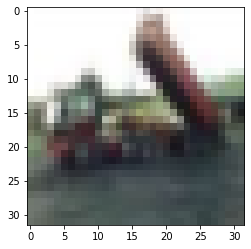

In [8]:
from matplotlib import pyplot as plt
plt.imshow(x_train[2])

In [9]:
N = len(x_train)
idx = np.arange(N)

In [10]:
#declare placeholders
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_actual = tf.placeholder(tf.float32,shape=[None,10])
keep_prob = tf.placeholder(tf.float32)

In [11]:
#setting up computation graph
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [12]:
with tf.variable_scope('conv_1',reuse=tf.AUTO_REUSE):
    W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, conv_fm1], stddev=1.0 / np.sqrt(NUM_CHANNELS * 9 * 9)), name='weights_1')
    b1 = tf.Variable(tf.zeros([conv_fm1]), name='biases_1')
    conv_1 = tf.nn.relu(tf.nn.conv2d(x, W1, [1, 1, 1, 1], padding='VALID') + b1)
    pool_1 = tf.nn.max_pool(conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool_1')
    print("W1_shape: {}, b1_shape: {}".format(tf.shape(W1),tf.shape(b1)))

W1_shape: Tensor("conv_1/Shape:0", shape=(4,), dtype=int32), b1_shape: Tensor("conv_1/Shape_1:0", shape=(1,), dtype=int32)


In [13]:
with tf.variable_scope('conv_2',reuse=tf.AUTO_REUSE):
    W2 = tf.Variable(tf.truncated_normal([5, 5, conv_fm1, conv_fm2], stddev=1.0 / np.sqrt(5 * 5 * conv_fm1)), name='weights_2')
    b2 = tf.Variable(tf.zeros([conv_fm2]), name='biases_2')
    conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1, 1, 1, 1], padding='SAME') + b2)
    pool_2 = tf.nn.max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool_2')
    print("W2_shape: {}, b2_shape: {}".format(tf.shape(W2),tf.shape(b2)))

W2_shape: Tensor("conv_2/Shape:0", shape=(4,), dtype=int32), b2_shape: Tensor("conv_2/Shape_1:0", shape=(1,), dtype=int32)


In [14]:
#flatten pool_2
dim2 = pool_2.get_shape()[1].value * pool_2.get_shape()[2].value * pool_2.get_shape()[3].value
pool_2_flat = tf.reshape(pool_2, [-1, dim2])

In [15]:
with tf.variable_scope('fc_1',reuse = tf.AUTO_REUSE):
    W_fc1 = tf.Variable(tf.truncated_normal([dim2, 300], stddev=1.0 / np.sqrt(dim2)), name='weights_3')
    b_fc1 = tf.Variable(tf.zeros([300]), name='biases_3')
    fc_1 = tf.nn.relu(tf.matmul(pool_2_flat, W_fc1) + b_fc1)
    print("W_fc1_shape: {}, b_fc1_shape: {}".format(tf.shape(W_fc1),tf.shape(b_fc1)))

W_fc1_shape: Tensor("fc_1/Shape:0", shape=(2,), dtype=int32), b_fc1_shape: Tensor("fc_1/Shape_1:0", shape=(1,), dtype=int32)


In [16]:
#add dropout layer
fc_1_drop = tf.nn.dropout(fc_1, keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
#predict output
W_fc2 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0 / np.sqrt(300)), name='weights_4')
b_fc2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_4')
y_pred = tf.matmul(fc_1_drop, W_fc2) + b_fc2
print("W_fc2_shape: {}, b_fc2_shape: {}".format(tf.shape(W_fc2),tf.shape(b_fc2)))

W_fc2_shape: Tensor("Shape:0", shape=(2,), dtype=int32), b_fc2_shape: Tensor("Shape_1:0", shape=(1,), dtype=int32)


In [18]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_actual,logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [19]:
with tf.variable_scope('acc',reuse = tf.AUTO_REUSE):
    matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_actual,1))
    acc = tf.reduce_mean(tf.cast(matches,tf.float32)) 

In [20]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_acc_list = []
    train_loss_list = []
    test_acc_list = []
    
    for epoch in range(10):
        #shuffle data 
        np.random.shuffle(idx)
        x_train, y_train = x_train[idx],y_train[idx]
        for start,end in zip(range(0,N,batch_size),range(batch_size,N,batch_size)):
            sess.run(train,feed_dict = {x:x_train[start:end], y_actual:y_train[start:end],keep_prob: 0.5})
        
        
        train_acc = acc.eval(feed_dict = {x:x_train[start:end], y_actual:y_train[start:end],keep_prob: 0.5})
        train_acc_list.append(train_acc)
        
        train_loss = cross_entropy.eval(feed_dict = {x:x_train[start:end], y_actual:y_train[start:end],keep_prob: 0.5})
        train_loss_list.append(train_loss)
        
        test_acc = acc.eval(feed_dict = {x:x_train[start:end], y_actual:y_train[start:end],keep_prob: 0.5})
        test_acc_list.append(test_acc)
        
        if epoch%2==0:
            print("Epoch: {}, Training accuracy: {}, Testing accuracy: {}, Training loss: {}".format(epoch,train_acc,test_acc,train_loss))
        elif epoch==9:
            print("W1_shape: {}, b1_shape: {}".format(tf.shape(W1),tf.shape(b1)))
           
    for var in tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES):
        weight = (sess.run([var]))[0].flatten().tolist()
        filename = (str(var).split())[1].replace('/', '_')
        filename = filename.replace("'", "").replace(':0', '') + '.txt'
        print("saving {}".format(filename))
        np.savetxt(str(filename), weight)

Epoch: 0, Training accuracy: 0.421999990940094, Testing accuracy: 0.4059999883174896, Training loss: 1.6116794347763062
Epoch: 2, Training accuracy: 0.4959999918937683, Testing accuracy: 0.49900001287460327, Training loss: 1.418580174446106
Epoch: 4, Training accuracy: 0.5720000267028809, Testing accuracy: 0.5809999704360962, Training loss: 1.1714320182800293
Epoch: 6, Training accuracy: 0.5839999914169312, Testing accuracy: 0.5809999704360962, Training loss: 1.1164593696594238
Epoch: 8, Training accuracy: 0.6259999871253967, Testing accuracy: 0.6399999856948853, Training loss: 1.0721182823181152
W1_shape: Tensor("Shape_2:0", shape=(4,), dtype=int32), b1_shape: Tensor("Shape_3:0", shape=(1,), dtype=int32)
saving conv_1_weights_1.txt
saving conv_1_biases_1.txt
saving conv_2_weights_2.txt
saving conv_2_biases_2.txt
saving fc_1_weights_3.txt
saving fc_1_biases_3.txt
saving weights_4.txt
saving biases_4.txt


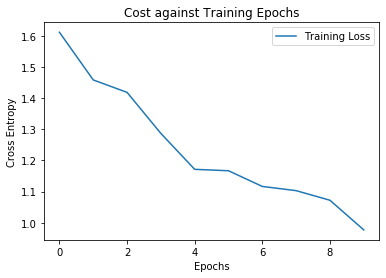

In [21]:
plt.figure()
plt.plot(range(10), train_loss_list, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.title("Cost against Training Epochs")
plt.legend()

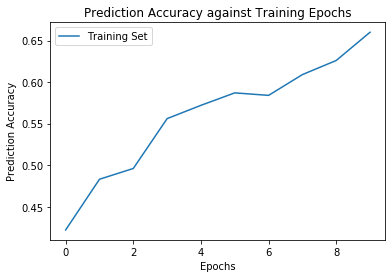

In [22]:
plt.figure()
plt.plot(range(10), train_acc_list, label='Training Set')
plt.xlabel('Epochs')
plt.ylabel('Prediction Accuracy')
plt.title("Prediction Accuracy against Training Epochs")
plt.legend()